
## Valutazione del Processo di Record Linkage

In questa sezione, introdurremo la valutazione del processo di record linkage utilizzando una ground truth più piccola e generata a mano. La ground truth rappresenta un insieme di dati di riferimento che ci permette di verificare l'accuratezza del nostro processo di record linkage. Utilizzando una ground truth ridotta e creata manualmente, possiamo ottenere una valutazione più precisa e dettagliata delle prestazioni del nostro algoritmo.


In [1]:
import pandas as pd

### Mo il punto é che la ground truth presenta solo alcuni casi, non tutti quindi procediamo a filtrare il dataframe

In [19]:
ground_truth = pd.read_csv('../ground_truth.csv')

#questo é con il primo metodo di record linkage
companies_df1 = pd.read_csv('../record_linkage/deduplicated_companies.csv')

#questo é con il secondo metodo di record linkage
companies_df2 = pd.read_csv('../record_linkage/deduplicated_companies2.csv')

## **Step 1: Filtraggio delle aziende nella Ground Truth**

In questa fase, filtriamo il dataset della ground truth per mantenere solo le aziende presenti nei dataset deduplicati. Questo ci permette di confrontare i risultati del record linkage solo con le entità per le quali abbiamo dati verificati.


In [15]:
from collections import defaultdict

# Creiamo un dizionario per raggruppare le aziende duplicate
ground_truth_groups = defaultdict(set)

for _, row in ground_truth.iterrows():
    ground_truth_groups[row['c1.company_name']].add(row['c2.company_name'])
    ground_truth_groups[row['c2.company_name']].add(row['c1.company_name'])

# Convertiamo i valori in liste
ground_truth_sets = [set([key] + list(values)) for key, values in ground_truth_groups.items()]



## **Step 2: Creazione delle Corrispondenze**

Dopo aver filtrato le aziende nella ground truth, estraiamo i record corrispondenti nei dataset deduplicati ottenuti con i due metodi di record linkage. Questo ci consente di valutare le differenze nei risultati prodotti dai due approcci.

In [16]:
def get_duplicate_groups(df):
    groups = defaultdict(set)
    for _, row in df.iterrows():
        groups[row['company_name']].add(row['company_name'])  # Aggiungiamo se stessi
    return [set(values) for values in groups.values()]

# Creiamo gruppi dai risultati
df1_groups = get_duplicate_groups(companies_df1)
df2_groups = get_duplicate_groups(companies_df2)


## **Step 3: Valutazione della Qualità del Record Linkage**

Confrontiamo le corrispondenze trovate nei dataset deduplicati con la ground truth, calcolando metriche di valutazione come precision, recall e F1-score. Questo ci permette di determinare quale metodo di record linkage ha prodotto i risultati più affidabili.

In [17]:
def evaluate_linkage(detected_groups, ground_truth_groups):
    true_positives = sum(1 for g in detected_groups if any(g & gt for gt in ground_truth_groups))
    false_positives = len(detected_groups) - true_positives
    false_negatives = sum(1 for gt in ground_truth_groups if not any(gt & g for g in detected_groups))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

precision1, recall1, f1_1 = evaluate_linkage(df1_groups, ground_truth_sets)
precision2, recall2, f1_2 = evaluate_linkage(df2_groups, ground_truth_sets)

print(f"Metodo 1 - Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1-score: {f1_1:.4f}")
print(f"Metodo 2 - Precision: {precision2:.4f}, Recall: {recall2:.4f}, F1-score: {f1_2:.4f}")


Metodo 1 - Precision: 0.0587, Recall: 0.5771, F1-score: 0.1065
Metodo 2 - Precision: 0.0029, Recall: 0.0086, F1-score: 0.0044


## **Step 4: Visualizzazione Grafica**

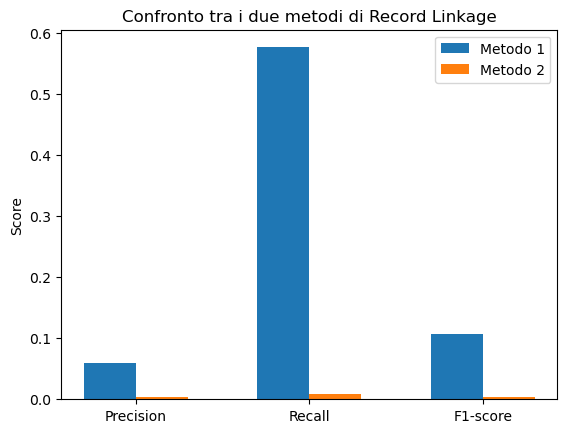

In [18]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Precision", "Recall", "F1-score"]
values1 = [precision1, recall1, f1_1]
values2 = [precision2, recall2, f1_2]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values1, width, label="Metodo 1")
bars2 = ax.bar(x + width/2, values2, width, label="Metodo 2")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylabel("Score")
ax.set_title("Confronto tra i due metodi di Record Linkage")

plt.show()